# Project 2 Model Workbook - Main Workbook with Models
---
Import cleaned data from prior steps.  
Select columns for model.  
Add dummies.  
Add polynomial features.  
Standard Scale  
And then run various models

---


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

% matplotlib inline

In [46]:
cleantrain = './datasets/train_nonulls8.csv'
cleantest =  './datasets/test_nonulls8.csv'

df = pd.read_csv(cleantrain)
df_test = pd.read_csv(cleantest)

y = df['SalePrice']                             # For train, save SalePrice in new var
df.drop('SalePrice', axis =1, inplace = True)   # For train, drop SalePrice and use new var
Id_y_hat = df_test['Id']                        # Save Ids for Kaggle output
train_Id = df['Id']                             # Save Ids from train data (need?)

y = np.log(y)                                 # y is skewed, taking log transform helps

# print(df.shape)
# print(df_test.shape)
# print(len(y))

#### Dummies
---
The functions below are tools to more easily allow for the addition of dummy variables to data.

---

In [47]:
# This code puts all columns names of non-numeric values into one variable
def get_dummy_list(df_in):
    a = df_in.dtypes == 'object'
    col_list_all = df_in.columns
    b = len(col_list_all)
    features = []
    for each in range(b):
        if a[each]:
            features.append(col_list_all[each])
    return(features)

# This takes a list of variables in and a dataframe.  It outputs the dataframe with dummy columns added
def add_dummies(dlist, df_in):
    df_out = pd.get_dummies(df_in, columns = dlist, drop_first = True)
    return(df_out)

# After dummy variables are created, the text based variables need to be removed from the data.
def remove_text_var(df_in):
    a = df_in.dtypes != 'object'
    col_list_all = df_in.columns
    b = len(col_list_all)
    features = []
    for each in range(b):
        if a[each]:
            features.append(col_list_all[each])
    return(df_in[features])

#### Polynomial Additions
---
The following functions make it easier to add polynomial variables to the data.  
A list of lists gets passed in as long as a dataframe.  
In this way, polynomial additions can be added by groups of variables rather than in one huge mass.  
The unify function is needed as well in case the dummies or polynomials results in different columns for train versus test data.

---

In [48]:
def add_poly(var_list, df_in):
    df_slice = df_in[var_list]                           #only poly the variables in list
    poly = PolynomialFeatures(2, include_bias = True, interaction_only=True)
    poly.fit(df_slice)
    new_vals = poly.transform(df_slice)
    new_names = poly.get_feature_names(df_slice.columns)
    a = dict(zip(new_names,new_vals.T))
    for each in a:
        df_in[each] = a[each]
    return(df_in)

def unify_columns(df1, df2):
    clist1 = set(df1.columns)
    clist2 = set(df2.columns)
    master_list = clist1.union(clist2)
    add_to_1 = list(master_list - clist1)
    add_to_2 = list(master_list - clist2)
  
    if len(add_to_1) > 0:
        for each in add_to_1:
            df1[each] = 0
    
    if len(add_to_2) > 0:
        for each in add_to_2:
            df2[each] = 0

    return (df1.sort_index(axis = 1), df2.sort_index(axis = 1))

### Variable Selection
---
The next section brings together the data and calls the functions above to create the dataset that will go into the regression.

---

In [49]:
col_all = df.columns

# These are dropped from model before considering correlations
# Generally they are columns that have been zeroed out from LassoCV.
# I've iterated through columns using top correlated in, Lasso out, etc.

cols_to_exclude = [
#                   'Low Qual Fin SF', '2nd Flr SF', '1st Flr SF',
#                   'BsmtFin SF 1', 'BsmtFin SF 2',
#                   'Misc Val', 'Misc Feature',
                   'Id', 'PID'
#                   'Garage Area', 'Garage Cars','Full Bath',
#                   'TotRms AbvGrd', 'Garage Yr Blt'
                  ]


cols_in = col_all.drop(cols_to_exclude)

train_model = df[cols_in]                                #only take cols_in into model
test_model = df_test[cols_in]

train_model = train_model.astype({"MS SubClass":str})    #This numeric column is a category
test_model = test_model.astype({"MS SubClass":str})      #If done in dataprep, it would
train_model = train_model.astype({"Mo Sold":str})        #have reversed when re-read
test_model = test_model.astype({"Mo Sold":str})




feat = get_dummy_list(train_model)                        #Add dummies for all non-numeric
feat.remove('Neighborhood')                               #Except I want my feature based on Neigh, not Neigh
train_model = add_dummies(feat, train_model)               
test_model = add_dummies(feat, test_model)

train_model = remove_text_var(train_model)                #remove non-numeric variable
test_model = remove_text_var(test_model)



---

The section below are the polynomial variables that the user wants to include in the model.  User input required.

---



In [50]:
#poly_list = [['Full Bath', 'Half Bath'],
#             ['Garage Cars', 'Garage Area'],
#             ['Wood Deck SF', 'Open Porch SF', 'Screen Porch'],
#             ['Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2'],
#             ['1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'TotRms AbvGrd'] ,
#             ['Year Built','Year Remod/Add','Yr Latest Change']
#            ]

#poly_list = [poly_all]

# Runs 20 on:
# poly_list = [['Garage Cars', 'Garage Area'],
#              ['Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2'],
#              ['1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'TotRms AbvGrd']
#             ]

# poly_list = [
#             ['1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'TotRms AbvGrd'],
#              ['Wood Deck SF', 'Open Porch SF', 'Screen Porch'],
#              ['Garage Cars', 'Garage Area'],
#              ['Full Bath', 'Half Bath'],
#              ['Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2']
#             ]

# for each in poly_list:
#     train_model = add_poly(each, train_model)
#     test_model = add_poly(each, test_model)


train_model, test_model = unify_columns(train_model, test_model)       # create columns where needed so cols match

---
The final step in pullling together the model is to make final variable selections.  I have chosen to pick those based on correlations (positive and negative) from all of the feature prep work above.

---

In [51]:
numb_vars = 20  # Actually twice this number of variables will be included.

top_corr = list(pd.concat([train_model, y], axis = 1).corr()['SalePrice'].sort_values(ascending = False).index[1:numb_vars+1])
top_neg_corr = list(pd.concat([train_model, y], axis = 1).corr()['SalePrice'].sort_values(ascending = True).index[0:numb_vars])

train_model_f = train_model[top_corr].copy()                 
test_model_f = test_model[top_corr].copy()                  

train_model_f[top_neg_corr] = train_model[top_neg_corr]          #final train data
test_model_f[top_neg_corr] = test_model[top_neg_corr]            #final test data

## Train Test Split
Now that the data is set up, we split the "train" dataset into train/test components so that we can test various modeling techniques.  Once a model is in shape to produce Kaggle output, the test_model above, the full train_model above will be used to calibrate the model and the test_model input will be used to make predictions.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train_model_f, y, random_state = 1929)

## To make sure the data is in good shape, run all cells above this point.  Select models to run and analyze below.

# Linear Regression with Pipeline workflow 

In [53]:
pipe = Pipeline([
#    ('pf', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

params_grid = {
    'ss__with_mean':[True, False],
    'ss__with_std':[True, False],
}

In [54]:
glr = GridSearchCV(pipe, params_grid, cv = 7, verbose = 1)
glr.fit(X_train, y_train)

Fitting 7 folds for each of 4 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.1s finished


GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ss__with_mean': [True, False], 'ss__with_std': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [55]:
print(glr.best_params_)
print(glr.score(X_train,y_train))
print(glr.score(X_test,y_test))

{'ss__with_mean': True, 'ss__with_std': True}
0.8617695954260531
0.871165524437985


In [ ]:
### Linear regression was clearly overfit when using Polynomial Features in the Pipeline.  
### Commenting out the PF gives a better model fit of 69% training R2 and 73% testing R2.  

In [56]:
# To run the model for Kaggle output
glr.fit(train_model_f, y)
y_hat_glr = glr.predict(test_model_f)
y_hat_glr_kaggle = np.exp(y_hat_glr)           # Depends on if y = ln(salesprice)



Fitting 7 folds for each of 4 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished


# Ridge with Pipeline workflow 

In [83]:
pipe2 = Pipeline([
    ('pf', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('rr', RidgeCV(alphas=np.logspace(0, 3, 1000)))
])

params_grid = {
    'ss__with_mean':[True, False],
    'ss__with_std':[True, False]#,
#    'rr__alphas': 
}

In [84]:
grr = GridSearchCV(pipe2, params_grid, cv = 2, verbose = 1)
grr.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.2s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rr', RidgeCV(alphas=array([   1.     ,    1.00694, ...,  993.10918, 1000.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ss__with_mean': [True, False], 'ss__with_std': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [85]:
print(max(grr.best_estimator_.named_steps['rr'].alphas))
print(min(grr.best_estimator_.named_steps['rr'].alphas))

1000.0
1.0


In [86]:
grr.best_estimator_.named_steps['rr'].alpha_

337.69803108250915

In [87]:
print(grr.best_params_)
print(grr.score(X_train,y_train))
print(grr.score(X_test,y_test))
#print(rr.alpha)


{'ss__with_mean': True, 'ss__with_std': True}
0.9263633886230804
0.8484340154488348


In [68]:
grr.fit(train_model_f, y)

y_hat_grr = grr.predict(test_model_f)
y_hat_grr_kaggle = np.exp(y_hat_grr)           # Depends on if y = ln(salesprice)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.9s finished


# Lasso with Pipeline workflow 

In [71]:
pipe3 = Pipeline([
    ('pf', PolynomialFeatures(interaction_only = True, include_bias = False)),
    ('ss', StandardScaler()),
    ('ls', LassoCV(max_iter=10000, cv=2, n_alphas = 500))
])

params_grid = {
#    'pf__interaction_only':[True, False],
#    'ls__alpha':np.linspace(1, 5000, 250)
    'ss__with_mean':[True, False],
#    'ls__alpha': np.linspace(1, 5000, 250),
#    'ls__positive':[True],
#    'ls__selection':['cyclic']
}

In [72]:
#pipe3.fit(X_train, y_train)

gl = GridSearchCV(pipe3, params_grid, verbose = 1)
gl.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pf', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ls', LassoCV(alphas=None, copy_X=True, cv=2, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=500, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ss__with_mean': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [250]:
# las_coef = pd.DataFrame({
#     'coefs': X_train.columns, #pipe3.named_steps['pf'].get_feature_names(X_train.columns),
#     'vals': pipe3.named_steps['ls'].coef_,
#     'abs val':abs(pipe3.named_steps['ls'].coef_)
# }).set_index('coefs').sort_values('abs val', ascending=False)

In [73]:
print(gl.best_params_)
print(gl.score(X_train,y_train))
print(gl.score(X_test,y_test))
#alpha?



{'ss__with_mean': True}
0.8984403677340671
0.8695339822956913


In [74]:
gl.fit(train_model_f, y)

y_hat_gl = gl.predict(test_model_f)
y_hat_gl_kaggle = np.exp(y_hat_gl)           # Depends on if y = ln(salesprice)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min finished


# ElasticNetCV with Pipeline workflow 

In [80]:
pipe4 = Pipeline([
    ('pf', PolynomialFeatures(interaction_only = True, include_bias = False)),
    ('ss', StandardScaler()),
    ('en', ElasticNetCV(max_iter = 10000))
])

params_grid = {
    'ss__with_mean':[True, False],
#    'ss__with_std':[True, False],
    'en__l1_ratio': [.01,.1, .2, .4, .55, .8, .9, .99],
#    'en__n_alphas':[25, 50, 100],
#    'en__selection':['cyclic','random']
}

In [81]:
gen = GridSearchCV(pipe4, params_grid, cv = 2, verbose = 2)
gen.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] en__l1_ratio=0.01, ss__with_mean=True ...........................
[CV] ............ en__l1_ratio=0.01, ss__with_mean=True, total=  17.6s
[CV] en__l1_ratio=0.01, ss__with_mean=True ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV] ............ en__l1_ratio=0.01, ss__with_mean=True, total=   8.0s
[CV] en__l1_ratio=0.01, ss__with_mean=False ..........................
[CV] ........... en__l1_ratio=0.01, ss__with_mean=False, total=  17.9s
[CV] en__l1_ratio=0.01, ss__with_mean=False ..........................
[CV] ........... en__l1_ratio=0.01, ss__with_mean=False, total=   9.0s
[CV] en__l1_ratio=0.1, ss__with_mean=True ............................
[CV] ............. en__l1_ratio=0.1, ss__with_mean=True, total=  11.0s
[CV] en__l1_ratio=0.1, ss__with_mean=True ............................
[CV] ............. en__l1_ratio=0.1, ss__with_mean=True, total=   7.8s
[CV] en__l1_ratio=0.1, ss__with_mean=False ...........................
[CV] ............ en__l1_ratio=0.1, ss__with_mean=False, total=  10.7s
[CV] en__l1_ratio=0.1, ss__with_mean=False ...........................
[CV] ............ en__l1_ratio=0.1, ss__with_mean=False, total=   7.6s
[CV] en__l1_ratio=0.2, ss__with_mean=True ............................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  7.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pf', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('en', ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=10000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ss__with_mean': [True, False], 'en__l1_ratio': [0.01, 0.1, 0.2, 0.4, 0.55, 0.8, 0.9, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [82]:
print(gen.best_params_)
print(gen.score(X_train,y_train))
print(gen.score(X_test,y_test))


{'en__l1_ratio': 0.01, 'ss__with_mean': True}
0.9156792059836643
0.8563779695463496


---
Fit above not great.

---

In [88]:
gen.fit(train_model_f, y)

y_hat_gen = gen.predict(test_model_f)
y_hat_gen_kaggle = np.exp(y_hat_gen)           # Depends on if y = ln(salesprice)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] en__l1_ratio=0.01, ss__with_mean=True ...........................
[CV] ............ en__l1_ratio=0.01, ss__with_mean=True, total=  14.2s
[CV] en__l1_ratio=0.01, ss__with_mean=True ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s


[CV] ............ en__l1_ratio=0.01, ss__with_mean=True, total=  14.8s
[CV] en__l1_ratio=0.01, ss__with_mean=False ..........................
[CV] ........... en__l1_ratio=0.01, ss__with_mean=False, total=  14.0s
[CV] en__l1_ratio=0.01, ss__with_mean=False ..........................
[CV] ........... en__l1_ratio=0.01, ss__with_mean=False, total=  14.8s
[CV] en__l1_ratio=0.1, ss__with_mean=True ............................
[CV] ............. en__l1_ratio=0.1, ss__with_mean=True, total=  11.5s
[CV] en__l1_ratio=0.1, ss__with_mean=True ............................
[CV] ............. en__l1_ratio=0.1, ss__with_mean=True, total=  12.9s
[CV] en__l1_ratio=0.1, ss__with_mean=False ...........................
[CV] ............ en__l1_ratio=0.1, ss__with_mean=False, total=  12.4s
[CV] en__l1_ratio=0.1, ss__with_mean=False ...........................
[CV] ............ en__l1_ratio=0.1, ss__with_mean=False, total=  12.4s
[CV] en__l1_ratio=0.2, ss__with_mean=True ............................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  9.1min finished


In [90]:
numb = 'fri90'

outfilelr = './submissions/'+numb+'_linreg.csv'
outfiler = './submissions/'+numb+'_ridge.csv'
outfilel = './submissions/'+numb+'_lasso.csv'
outfilee = './submissions/'+numb+'_en.csv'

out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':y_hat_glr_kaggle})
out_to_kaggle.to_csv(outfilelr, index = False)

out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':y_hat_grr_kaggle})
out_to_kaggle.to_csv(outfiler, index = False)

out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':y_hat_gl_kaggle})
out_to_kaggle.to_csv(outfilel, index = False)

out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':y_hat_gen_kaggle})
out_to_kaggle.to_csv(outfilee, index = False)



# Plotting residuals to see if there is a trend (higher for one model vs the other at various ends).

In [ ]:
# linear regression results with ln(sale_price)
y_train.head()

In [19]:
#gl.fit(X_test,y_test)
#Y1 is linear regression
#y2 is lasso
y_lin = np.exp(glr.predict(X_test))
y_lass = np.exp(gl.predict(X_test))
y_t = np.exp(y_test)

In [45]:
y_en = np.exp(gen.predict(X_test))

In [396]:
#y_pipe3 = np.exp(pipe3.predict(X_test))
y_pipe4 = np.exp(pipe3.predict(X_test))    # from training set, using 30 up & down vars

In [397]:
preds = pd.DataFrame({
    'y':y_t,
    'y1':y_pipe3,
    'y2':y_pipe4
})

In [453]:
preds['res_y1'] = (preds['y'] - preds['y1'])
preds['res_y2'] = (preds['y'] - preds['y2'])
preds = preds.sort_values('y')

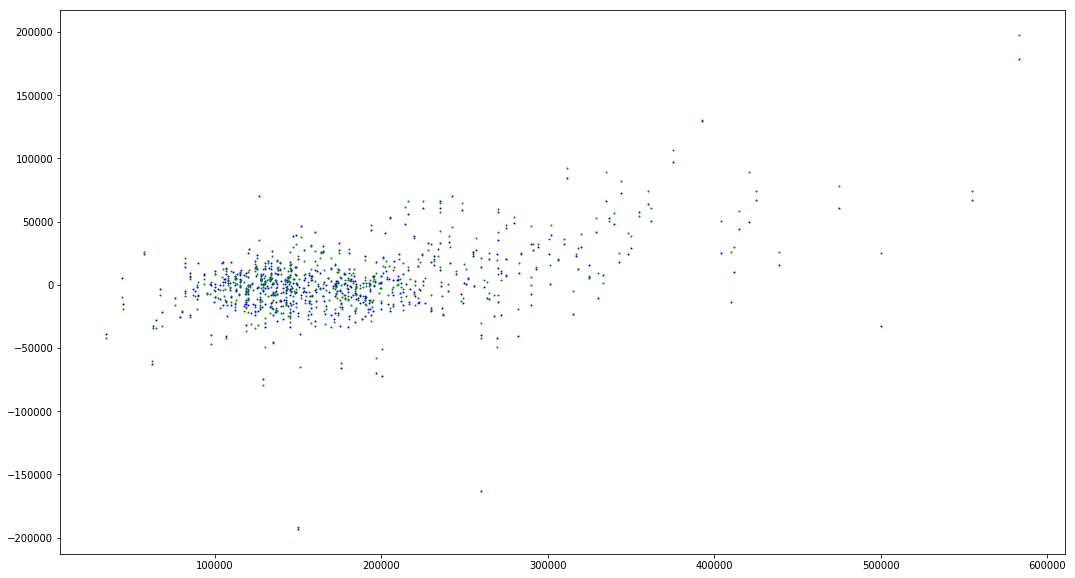

In [454]:
plt.figure(figsize = (18, 10))
plt.scatter(preds['y'], preds['res_y1'], color = 'b', s = 1)

plt.scatter(preds['y'], preds['res_y2'], color = 'g', s = 1)

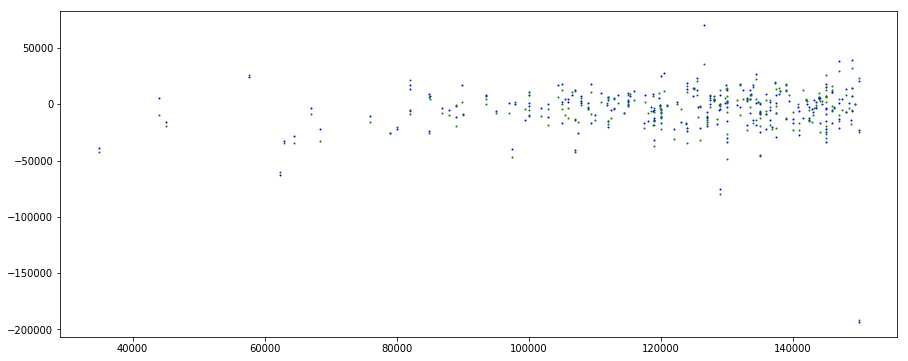

In [455]:
plt.figure(figsize = (15, 6))
g = preds[preds['y'] < 150000]
plt.scatter(g['y'], g['res_y1'], color = 'b', s = 1)
plt.scatter(g['y'], g['res_y2'], color = 'g', s = 1)

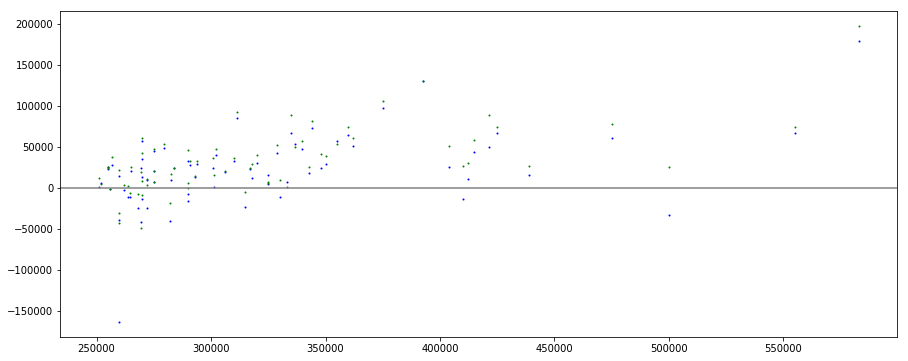

In [458]:
plt.figure(figsize = (15, 6))
g = preds[preds['y'] >= 250000]
plt.scatter(g['y'], g['res_y1'], color = 'b', s = 1)
plt.scatter(g['y'], g['res_y2'], color = 'g', s = 1)
plt.axhline(0, color="gray")

In [402]:
preds['res_y1'].sum()/preds['res_y2'].sum()

0.9755740981596467

In [403]:
preds['diff'] = preds['res_y1'] - preds['res_y2']       # difference in error terms
preds['cum_diff'] = preds['diff'].cumsum()

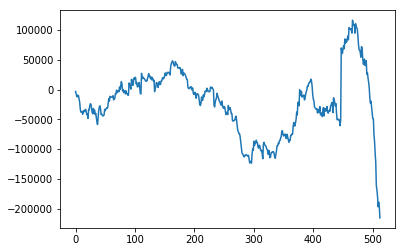

In [404]:
#preds = preds.sort_values('y1')
plt.plot(range(len(preds)), preds['cum_diff'])

In [449]:
a = 120000
b = 380000
preds['condition'] = ((preds['y1'] < a) & (preds['y1'] < a))* 1
preds['y_combo'] = preds['condition']*preds['y2'] + preds['y1']*(1-preds['condition'])
#kag['out2'] = kag['condition']* kag['en'] + (1-kag['condition'])*kag['lr']
#preds['y_combo']=

In [450]:
preds['y_comb_res'] = abs(preds['y']-preds['y_combo'])

In [451]:
print(preds['y_comb_res'].sum())
print(preds['res_y1'].sum())
print(preds['res_y2'].sum())

8490043.311192004
8603674.265104303
8819088.454003178


In [445]:
for each in range(50000, 450000, 10000):
    a = each
    b = a
    preds['condition'] = ((preds['y1'] < a) & (preds['y1'] < b))* 1
    preds['y_combo'] = preds['condition']*preds['y2'] + preds['y1']*(1-preds['condition'])
    preds['y_comb_res'] = abs(preds['y']-preds['y_combo'])
    print(each, preds['y_comb_res'].sum())

50000 8608831.645326976
60000 8574455.834961506
70000 8577689.882037397
80000 8565754.188329656
90000 8554000.123160092
100000 8541827.74059898
110000 8505116.312318847
120000 8490043.311192004
130000 8507898.256950354
140000 8514955.902372546
150000 8556843.052012563
160000 8627985.942885466
170000 8608288.457166031
180000 8630344.880594498
190000 8679345.839149158
200000 8737407.699722791
210000 8740361.290539619
220000 8679077.413050152
230000 8731438.39406579
240000 8735657.540862765
250000 8741049.624682011
260000 8746088.257696511
270000 8772337.201869205
280000 8779701.726495817
290000 8794727.636803538
300000 8765169.838806553
310000 8771483.69558955
320000 8788566.936523173
330000 8794725.22462586
340000 8777038.679265438
350000 8773869.93883137
360000 8780814.880693963
370000 8780814.880693963
380000 8860986.301388137
390000 8860986.301388137
400000 8860986.301388137
410000 8899574.077811334
420000 8917165.250066075
430000 8819078.543490222
440000 8819078.543490222


In [409]:
preds[:50]

,y,y1,y2,res_y1,res_y2,diff,cum_diff,condition,y_combo
1309,34900.0,73666.890955,77027.086233,38766.890955,42127.086233,-3360.195278,-3360.195278,0,73666.890955
103,44000.0,38273.518336,53327.409334,5726.481664,9327.409334,-3600.927670,-6961.122948,0,38273.518336
1089,45000.0,60340.381317,64313.105126,15340.381317,19313.105126,-3972.723809,-10933.846757,0,60340.381317
581,57625.0,33023.263928,31466.811375,24601.736072,26158.188625,-1556.452553,-12490.299310,0,33023.263928
508,62383.0,125446.434974,122333.721935,63063.434974,59950.721935,3112.713039,-9377.586271,0,125446.434974
1394,63000.0,95893.747344,97072.573817,32893.747344,34072.573817,-1178.826473,-10556.412743,0,95893.747344
1823,64500.0,92411.091214,98485.162455,27911.091214,33985.162455,-6074.071240,-16630.483984,0,92411.091214
814,67000.0,70242.340221,75407.214814,3242.340221,8407.214814,-5164.874593,-21795.358577,0,70242.340221
1945,68400.0,89888.895309,101030.448637,21488.895309,32630.448637,-11141.553328,-32936.911905,0,89888.895309
53,76000.0,86717.068853,91666.733311,10717.068853,15666.733311,-4949.664458,-37886.576363,0,86717.068853


In [57]:
preds.iloc[200,:]

y           145000.000000
y1          131039.170909
y2          130996.845324
res_y1       13960.829091
res_y2       14003.154676
diff           -42.325585
cum_diff     38973.197433
Name: 329, dtype: float64

In [58]:
preds.iloc[375,:]

y           200825.000000
y1          181639.795856
y2          180996.298737
res_y1       19185.204144
res_y2       19828.701263
diff          -643.497119
cum_diff     32677.591094
Name: 1291, dtype: float64

In [452]:
preds.tail(25)

,y,y1,y2,res_y1,res_y2,diff,cum_diff,condition,y_combo,y_comb_res
1551,330000.0,340706.244611,320970.592052,10706.244611,9029.407948,1676.836663,41933.349319,0,340706.244611,10706.244611
1909,333168.0,325569.594341,331913.303987,7598.405659,1254.696013,6343.709645,48277.058965,0,325569.594341,7598.405659
865,335000.0,268555.393159,245833.615895,66444.606841,89166.384105,-22721.777264,25555.281701,0,268555.393159,66444.606841
1815,336820.0,283956.789607,286709.358961,52863.210393,50110.641039,2752.569353,28307.851054,0,283956.789607,52863.210393
1421,339750.0,291927.392393,282906.853272,47822.607607,56843.146728,-9020.539122,19287.311933,0,291927.392393,47822.607607
1630,342643.0,324593.354861,317641.990253,18049.645139,25001.009747,-6951.364608,12335.947325,0,324593.354861,18049.645139
22,344133.0,271287.022230,262193.854927,72845.977770,81939.145073,-9093.167303,3242.780022,0,271287.022230,72845.977770
1970,348000.0,323614.508574,307121.553566,24385.491426,40878.446434,-16492.955009,-13250.174987,0,323614.508574,24385.491426
1056,350000.0,320711.803075,311046.637311,29288.196925,38953.362689,-9665.165764,-22915.340751,0,320711.803075,29288.196925
1087,355000.0,297542.258099,300933.587617,57457.741901,54066.412383,3391.329519,-19524.011233,0,297542.258099,57457.741901


In [61]:
# idea -- use lr until predictions are around $130k, use EN from $130k to $180k, use lr for values higher than $180k.
glr.fit(train_model_f, y)
ylr_k = np.exp(glr.predict(test_model_f))

gen.fit(train_model_f,y)
yen_k = np.exp(gen.predict(test_model_f))

Fitting 7 folds for each of 4 candidates, totalling 28 fits
Fitting 7 folds for each of 168 candidates, totalling 1176 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1176 out of 1176 | elapsed:   37.0s finished


In [380]:
y24 = np.exp(pipe3.predict(test_model_f))

In [62]:
kag = pd.DataFrame({
    'lr':ylr_k,
    'en':yen_k
})

In [63]:
kag['out'] = kag['lr']

In [77]:
kag.head()

,en,lr,out,condition
0,104492.356053,102009.626458,102009.626458,0
1,164822.346366,164024.037740,164024.037740,1
2,204503.906576,204271.217257,204271.217257,0
3,104475.316659,104096.287802,104096.287802,0
4,181680.136244,182875.149273,182875.149273,0


In [79]:
kag['condition'] = ((kag['lr'] > 130000) & (kag['lr'] < 180000))* 1
kag['out2'] = kag['condition']* kag['en'] + (1-kag['condition'])*kag['lr']

In [85]:
kag.tail()

,en,lr,out,condition,out2
874,185150.845427,184253.470705,184253.470705,0,184253.470705
875,210066.764864,209717.861242,209717.861242,0,209717.861242
876,135684.653318,136045.482857,136045.482857,1,135684.653318
877,113355.283269,113047.317942,113047.317942,0,113047.317942
878,126615.411140,126662.338898,126662.338898,0,126662.338898


In [82]:
numb = 'blend01'
outfileb = './submissions/'+numb+'_b.csv'
out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':kag['out2']})
out_to_kaggle.to_csv(outfileb, index = False)

In [90]:
kag['condition'] = ((kag['lr'] < 325000))* 1
kag['out2'] = kag['condition']* kag['en'] + (1-kag['condition'])*kag['lr']
numb = 'blend02'
outfileb = './submissions/'+numb+'_b.csv'
out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':kag['out2']})
out_to_kaggle.to_csv(outfileb, index = False)

In [91]:
kag['condition'] = ((kag['lr'] < 130000))* 1
kag['out2'] = kag['condition']* kag['en'] + (1-kag['condition'])*kag['lr']
numb = 'blend03'
outfileb = './submissions/'+numb+'_b.csv'
out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':kag['out2']})
out_to_kaggle.to_csv(outfileb, index = False)

In [334]:
numb = 'fs02bl'
outfileb = './submissions/'+numb+'.csv'
out_to_kaggle = pd.DataFrame({'Id':Id_y_hat, 'SalePrice':preds['y_combo'])
out_to_kaggle.to_csv(outfileb, index = False)

In [235]:
len(y_07_predict)

879

In [238]:
y_01_predict

array([12006.82711254, 13268.69536949, 19131.24506528, 11513.956297  ,
       16473.00180186, 12875.92004473, 12895.71866359, 13053.86413   ,
       19364.3071705 , 16956.47231496, 16185.18994574, 14677.43708163,
       17084.29329215, 20624.96213674, 13805.81130153, 12923.84059586,
       14316.20787606, 13368.96301898, 17160.11505523, 17395.86675752,
       14620.12575507, 14981.96088069, 17960.31411781, 17961.15207394,
       19088.70742005, 13757.81863788, 13047.32698897, 11170.32023299,
       18171.41908619, 10483.70249402, 14337.15295744,  9963.93203519,
       17365.83240425, 16375.3756646 , 20843.22164288, 19651.83274477,
       11162.51949325, 11376.81587413, 14296.62066602, 17522.73993562,
       17605.90000994, 19155.22636361, 15752.25005225, 15010.1583795 ,
       20140.88639972, 12696.513364  , 20800.54462041, 13781.61630054,
       15230.70741169, 14140.97540182, 12516.60068696, 15714.32357731,
       26483.05441954, 13440.7267563 , 12658.61994713, 17953.50600406,
      